In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
import sys
import json
warnings.filterwarnings("ignore")

In [2]:
start = time.time()
specs = pd.read_csv('./data/specs.csv')
trainX = pd.read_csv('./data/train.csv')
print(time.time()-start)

66.36481642723083


In [2]:
train_label = pd.read_csv('./data/train_labels.csv')
testX = pd.read_csv('./data/test.csv')

In [4]:
trainX.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [6]:
traind = trainX['game_time'].values[1:] - trainX['game_time'].values[:-1]    #將game_time轉換成時間差
traind = np.concatenate((np.zeros(1),traind),axis=0)                         #原先為累計時間                                               ## 或許直接增加一行更好 
trainX['game_time_dif'] = traind/1000
trainX['game_time_dif'] = trainX['game_time_dif'].map(lambda x : (x + abs(x)) / 2)
del traind

In [5]:
shape = trainX.shape
print(f'Train shape : {shape}')
num_player = trainX['installation_id'].nunique()
print(f'共有{num_player}個ID')
columns_name = list(trainX.columns)
print(columns_name)

Train shape : (11341042, 11)
共有17000個ID
['event_id', 'game_session', 'timestamp', 'event_data', 'installation_id', 'event_count', 'event_code', 'game_time', 'title', 'type', 'world']


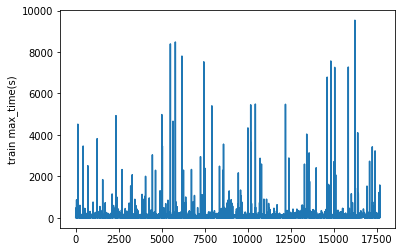

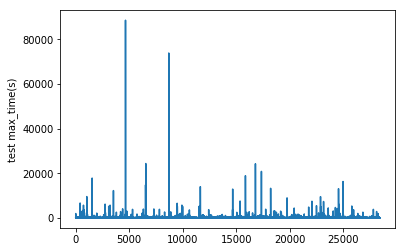

In [40]:
mm = trainX.groupby(['installation_id', 'game_session'])['game_time'].max()
mt = testX.groupby(['installation_id', 'game_session'])['game_time'].max()
plt.plot(np.arange(mm.shape[0]), mm.values/1000)
plt.ylabel('train max_time(s)')
plt.show()
plt.plot(np.arange(mt.shape[0]), mt.values/1000)
plt.ylabel('test max_time(s)')
plt.show()
del mm, mt

可以看到有幾項特別高的 甚至到100000秒以上 約為一天 表示手機開著就沒關啦 或許把超過三小時的刪掉會比較好(10800000秒)

In [8]:
trainX['timestamp'] = pd.to_datetime(trainX['timestamp'])          #將時間型特徵拆開來
trainX['date'] = trainX['timestamp'].dt.date
trainX['hour'] = trainX['timestamp'].dt.hour
trainX['weekday_name'] = trainX['timestamp'].dt.weekday_name
trainX = trainX.drop(['timestamp'], axis=1)
trainX['hour'] = trainX['hour']/24

發現 id 為f1c21eda的玩家似乎有問題 遊玩次數遠大於其他玩家 將其刪掉

In [41]:
trainX = trainX[trainX['installation_id'] != 'f1c21eda']

可以合理推斷 如果玩越多天 對遊戲應該越熟練 則通關率會越高 所以可以將date做label encoder 數字越高通過可能越高

In [42]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
aa = trainX.groupby('installation_id')['date'].apply(lambda x : LE.fit_transform(x))
con = np.concatenate((aa[0],aa[1]))
for i in range(aa.shape[0]-2):
    con = np.concatenate((con,aa[i+2]))
trainX['date'] = con    
del con

In [5]:
assess = ['Bird Measurer (Assessment)' , 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Mushroom Sorter (Assessment)']
num_ass = trainX[trainX['title'].apply(lambda x : x in assess)]
nt = num_ass[(num_ass['event_code'] == 4100) | (num_ass['event_code'] == 4110)]['game_session'].unique()
nl = train_label['game_session'].unique()
nt = list(nt)
nl = list(nl)
set(nt) - set(nl)

In [8]:
trainX = trainX[trainX['game_session'].apply(lambda x : x in train_label['game_session'].unique())]   #把沒有做過測驗的刪掉

In [11]:
trainX.to_csv('trainX2.csv', index = False)

In [253]:
trainX = pd.read_csv('trainX2.csv')

In [ ]:
trainX = trainX[trainX['game_time']/1000 < 10000]

發現有些event_count順序是錯的  ex:'c1fd206b608ef6ac'

In [280]:
cor = trainX.groupby('game_session').apply(lambda x : x.sort_values(by = ['event_count']))
zz = cor.droplevel(0)
zz.to_csv('trainXX.csv', index=None)

In [3]:
trainX = pd.read_csv('trainXX.csv')    #修復完順序的

In [10]:
trainX['game_time_dif'].describe()      #平均每次事件遊玩時間為1.多秒 std為5X

count    865162.000000
mean          1.448206
std          53.448084
min           0.000000
25%           0.099000
50%           0.628000
75%           1.253000
max       26414.524000
Name: game_time_dif, dtype: float64

In [58]:
trainX = pd.get_dummies(trainX, columns = ['event_id', 'event_code'])

In [61]:
trainX = trainX.drop(['event_data'], axis=1)

In [23]:
acc1 = train_label['game_session'].unique()
acc2 = train_label['accuracy'].values
game_acc = []
for i in range(len(acc1)):
    game_acc.append((acc1[i],acc2[i]))
game_acc = dict(game_acc)    
trainX['grade'] = trainX['game_session'].map(lambda x : game_acc.get(x))

In [130]:
title_mean = train_label.groupby('title').apply(lambda x : x.mean())
title_acc = []
for i in title_mean.index:
    title_acc.append((i,title_mean.loc[i]['accuracy']))
title_acc = dict(title_acc)  
trainX['grade_title'] = trainX['title'].map(lambda x : title_acc.get(x))

In [99]:
acc_group = train_label['accuracy_group'].values
trainy = []
for i in range(len(acc1)):
    trainy.append((acc1[i],acc_group[i]))
trainy = dict(trainy)    
#trainX['label'] = trainX['game_session'].map(lambda x : trainy.get(x))
#trainX = trainX.drop(['label'], axis=1)

對type world title 做one-hot

再把星期幾分為假日跟平日

In [ ]:
trainX = pd.get_dummies(trainX, columns= ['type', 'world', 'title'])
weekend = ['Statuday', 'Sunday']
trainX['weekday_name'] = trainX['weekday_name'].map(lambda x : int(x in weekend))

In [140]:
trainX = trainX[trainX['installation_id']!= 'f1c21eda']        #遊玩次數異常
trainX = trainX[trainX['installation_id'] != '08987c08']
trainX = trainX.drop(['game_time'],axis=1)

In [164]:
ind1 = (trainX.groupby('installation_id')['game_session'].nunique()==1)
ind2 = []
for i in ind1.index:
    if ind1.loc[i] == True:
        ind2.append(i)
trainX = trainX[trainX['installation_id'].map(lambda x : x not in ind2)]        

In [144]:
count_new = trainX.groupby('game_session')['event_count'].apply(lambda x : (x-x.min())/(x.max() - x.min()))
trainX['event_count'] = count_new

In [168]:
dif_new = trainX.groupby('game_session')['game_time_dif'].apply(lambda x : (x-x.min())/(x.max() - x.min()))
trainX['game_time_dif'] = dif_new

In [177]:
trainX.to_csv('trainXXX.csv',index=False)

In [3]:
trainX = pd.read_csv('trainXXX.csv')

In [4]:
trainX.head()

,game_session,installation_id,event_count,game_time_dif,date,hour,weekday_name,type_Assessment,world_CRYSTALCAVES,world_MAGMAPEAK,...,event_code_4030,event_code_4035,event_code_4040,event_code_4070,event_code_4080,event_code_4090,event_code_4100,event_code_4110,grade,grade_title
0,00097cda27afb726,01bdd720,0.000000,0.000000,0,0.666667,1,1,0,0,...,0,0,0,0,0,0,0,0,1.0,0.711042
1,00097cda27afb726,01bdd720,0.028571,0.000000,0,0.666667,1,1,0,0,...,0,0,0,0,0,0,0,0,1.0,0.711042
2,00097cda27afb726,01bdd720,0.057143,0.000000,0,0.666667,1,1,0,0,...,0,0,0,0,0,0,0,0,1.0,0.711042
3,00097cda27afb726,01bdd720,0.085714,0.938571,0,0.666667,1,1,0,0,...,0,0,0,1,0,0,0,0,1.0,0.711042
4,00097cda27afb726,01bdd720,0.114286,0.000000,0,0.666667,1,1,0,0,...,0,0,0,0,0,0,0,0,1.0,0.711042


In [24]:
def game_length(x):
    length = trainX[trainX['game_session'] == x].shape[0]
    return length
acc_mean = trainX.groupby('installation_id')['game_session'].apply(lambda x : x.iloc[:-game_length(x.iloc[-1])].map(lambda x : game_acc.get(x)))

In [49]:
acc_mean_group = acc_mean.mean(level = 'installation_id')
last_game = trainX.groupby('installation_id')['game_session'].apply(lambda x : x.iloc[-1])

In [92]:
train = trainX[trainX['game_session'] == last_game[0]].iloc[0]
for i in range(last_game.shape[0]-1):
    train2 = trainX[trainX['game_session'] == last_game[i+1]].iloc[0]
    train = pd.concat([train,train2],axis=1)
train = train.T    

In [97]:
train = train.drop(['grade'], axis=1)
train['grade_mean'] = train['installation_id'].map(lambda x : acc_mean_group[x])
train['label'] = train['game_session'].map(lambda x : trainy.get(x))

In [104]:
ids = train['installation_id']
game_se = train['game_session']
labels = train['label']
train = train.drop(['installation_id', 'game_session', 'label'],axis=1)

In [108]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(train,labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [217]:
testX = pd.read_csv('./data/test.csv')

In [218]:
traind = testX['game_time'].values[1:] - testX['game_time'].values[:-1]    #將game_time轉換成時間差
traind = np.concatenate((np.zeros(1),traind),axis=0)                         #原先為累計時間                                               ## 或許直接增加一行更好 
testX['game_time_dif'] = traind/1000
testX['game_time_dif'] = testX['game_time_dif'].map(lambda x : (x + abs(x)) / 2)
del traind

In [219]:
testX['timestamp'] = pd.to_datetime(testX['timestamp'])          #將時間型特徵拆開來
testX['date'] = testX['timestamp'].dt.date
testX['hour'] = testX['timestamp'].dt.hour
testX['weekday_name'] = testX['timestamp'].dt.weekday_name
testX = testX.drop(['timestamp'], axis=1)
testX['hour'] = testX['hour']/24

In [220]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
aa = testX.groupby('installation_id')['date'].apply(lambda x : LE.fit_transform(x))
con = np.concatenate((aa[0],aa[1]))
for i in range(aa.shape[0]-2):
    con = np.concatenate((con,aa[i+2]))
testX['date'] = con    
del con

In [221]:
testX['title_acc'] = testX['title'].map(lambda x : title_acc.get(x))

In [222]:
testX['TF'] = testX['event_data'].map(lambda x : json.loads(x).get('correct'))

In [224]:
def TFcon(x):
    f = x == False
    t = x == True
    acc = t.sum() / (f.sum() + t.sum())
    return acc
acc_test = testX.groupby('game_session')['TF'].apply(lambda x : TFcon(x))
acc_test = acc_test.dropna()

In [225]:
def game_length(x):
    length = testX[testX['game_session'] == x].shape[0]
    return length
acc_meant = testX.groupby('installation_id')['game_session'].apply(lambda x : x.iloc[:-game_length(x.iloc[-1])].map(lambda x : acc_test.get(x)))
acc_meant_group = acc_meant.fillna(0).mean(level = 'installation_id')

In [226]:
def acc_mean_con(x):
    try:
        return acc_meant_group[x]
    except:
        return 0
testX['grade_mean'] = testX['installation_id'].map(lambda x : acc_mean_con(x))

In [191]:
dif_new = testX.groupby('game_session')['game_time_dif'].apply(lambda x : (x-x.min())/(x.max() - x.min()))
testX['game_time_dif'] = dif_new

In [227]:
last_game_test = testX.groupby('installation_id')['game_session'].apply(lambda x : x.iloc[-1])

In [228]:
testX = pd.get_dummies(testX, columns= ['type', 'world', 'title'])
weekend = ['Statuday', 'Sunday']
testX['weekday_name'] = testX['weekday_name'].map(lambda x : int(x in weekend))

In [230]:
testX = testX.drop(['event_data','game_time'], axis=1)

In [212]:
testX = pd.get_dummies(testX, columns = ['event_id', 'event_code'])
testX = testX.drop(['event_data'],axis=1)

In [252]:
test = testX[testX['game_session'].map(lambda x : x in last_game_test.values)]

In [258]:
test = pd.get_dummies(test, columns = ['event_code','event_id'])

In [274]:
for i in test.columns:
    if test[i].nunique() == 1:
        test = test.drop([i], axis=1)

In [283]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(train,labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [284]:
pre = gbc.predict(test)

In [292]:
predict = pd.DataFrame()
predict['installation_id'] = ids_test
predict['accuracy_group'] = pre

In [294]:
predict.to_csv('predict.csv', index = None)